1. Construct a signal with high-frequency noise

In [2]:
import numpy as np
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
import matplotlib.pyplot as plt

sample_rate = 100.0
nsamples = 1024


t = arange(nsamples) / sample_rate
signal = ((cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)).astype(np.float32))/2

2. Create a FIR Low Pass filter

In [19]:
# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# Set the desired filter length
desired_length = 64  

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
# N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

N, beta = kaiserord(ripple_db, width)


desired_length = 128

# Use firwin with a Kaiser window to create a lowpass FIR filter.
hpf_coeffs = (firwin(desired_length, cutoff_hz/nyq_rate, window=('kaiser', beta))).astype(np.float32)

lpf_coeffs_quant = np.array(hpf_coeffs)
lpf_coeffs_hw = np.int32(lpf_coeffs_quant/np.max(abs(lpf_coeffs_quant)) * 2**15 - 1)

filter_len= len(lpf_coeffs_hw)

print('compute_len =',N)
print('filter_len =',filter_len)
print(lpf_coeffs_hw)

compute_len = 74
filter_len = 128
[   12    20    21     9   -13   -40   -58   -55   -24    26    81   115
   105    44   -52  -151  -208  -187   -80    86   250   341   302   125
  -139  -396  -533  -469  -195   209   595   796   696   286  -311  -876
 -1167 -1017  -419   449  1269  1691  1474   607  -657 -1858 -2486 -2182
  -906   986  2825  3836  3426  1453 -1629 -4820 -6822 -6425 -2923  3593
 12161 21126 28558 32767 32767 28558 21126 12161  3593 -2923 -6425 -6822
 -4820 -1629  1453  3426  3836  2825   986  -906 -2182 -2486 -1858  -657
   607  1474  1691  1269   449  -419 -1017 -1167  -876  -311   286   696
   796   595   209  -195  -469  -533  -396  -139   125   302   341   250
    86   -80  -187  -208  -151   -52    44   105   115    81    26   -24
   -55   -58   -40   -13     9    21    20    12]


3. Plot the FIR filter coefficients.

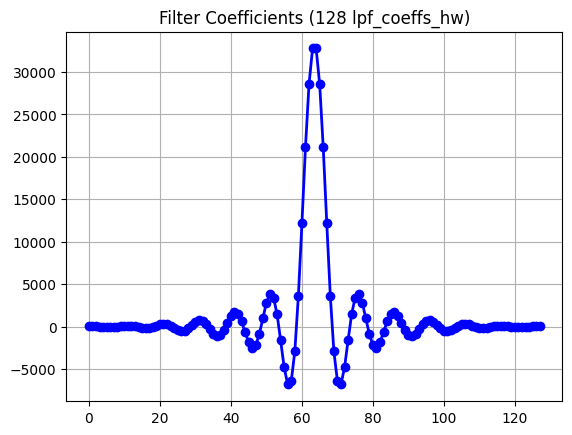

In [20]:
figure(1)
plot(lpf_coeffs_hw, 'bo-', linewidth=2)
title('Filter Coefficients (%d lpf_coeffs_hw)' % filter_len)
grid(True)


The signals are quantified according to the requirements and generated into the format required by AIE

In [21]:
def vector2file_cint16(data: np.array, file: str, plio = 128, bits = 16, scale: bool=True):
    """
    data: samples
    file: output filename
    plio: bit width of the PLIO port
    bits: bit precision per sample
    """
    """Scale signal to use full precision"""
    maxr = np.max(np.abs(data.real))
    maxi = np.max(np.abs(data.imag))
    maxv = maxr if maxr > maxi else maxi
    vscale = 2**int(np.floor(np.log2((1 << (bits-1)) / maxv)))
    data = data * (vscale if scale else 1)
    """Write value to file"""
    with open(file, 'w', newline='') as f:
        for i, v in enumerate(data):
            r = np.int16(v.real)
            c = np.int16(v.imag)
            f.write("{} {} ".format(r, c))
            if (((i+1) % 4) == 0 and plio == 128) or (((i+1) % 2) == 1 and plio == 64):
                f.write('\n')
    
    return vscale


def vector2file_int16(data: np.array, file: str, plio = 128, bits = 16, scale: bool=True):
    """
    data: samples
    file: output filename
    plio: bit width of the PLIO port
    bits: bit precision per sample
    """
    """Scale signal to use full precision"""
    maxr = np.max(np.abs(data.real))
    maxv = maxr
    vscale = 2**int(np.floor(np.log2((1 << (bits-1)) / maxv)))
    data = data * (vscale if scale else 1)
    """Write value to file"""
    with open(file, 'w', newline='') as f:
        for i, v in enumerate(data):
            r = np.int16(v.real)
            f.write("{} ".format(r))
            if (((i+1) % 8) == 0 and plio == 128) or (((i+1) % 2) == 1 and plio == 64):
                f.write('\n')
    
    return vscale

4. Generate the input vector file

In [18]:
vector2file_int16(signal, 'input.txt', scale=True)
vector2file_int16(lpf_coeffs_hw, 'coeffs.txt', scale=True)

1

Plot the magnitude response of the filter.

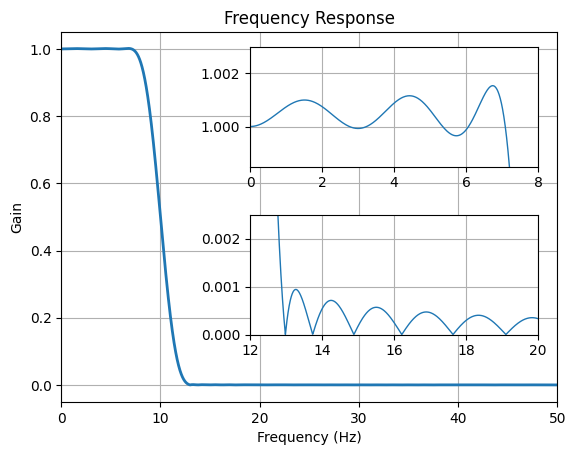

In [16]:
figure(2)
clf()
w, h = freqz(hpf_coeffs, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
xlim(0,50)
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=1)
xlim(0,8.0)
ylim(0.9985, 1.003)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=1)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

5. Apply the filter to signal using lfilter and Plot the original and filtered signals

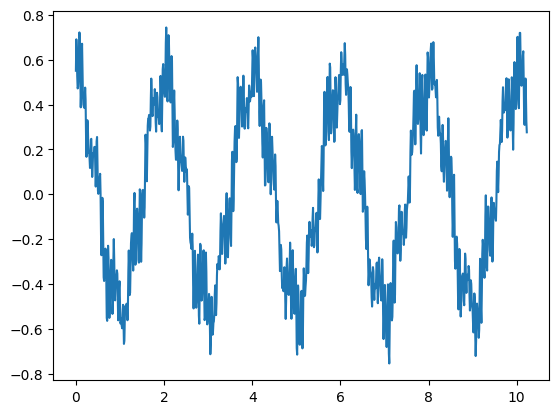

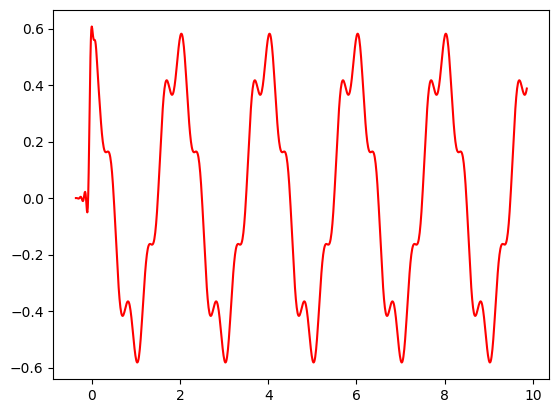

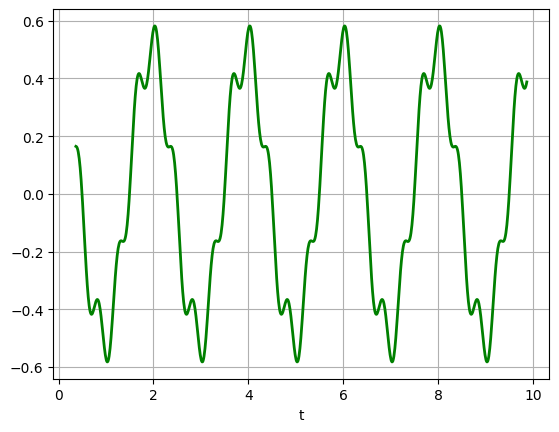

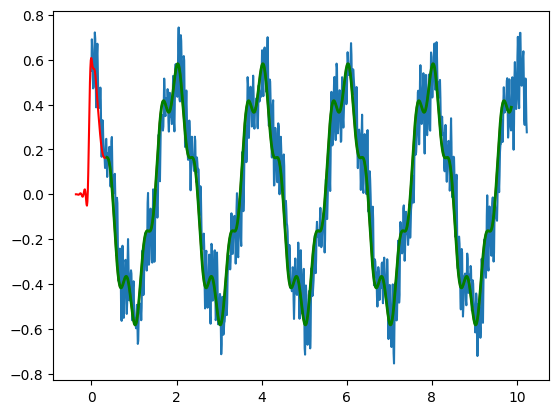

In [17]:
# Use lfilter to filter signal with the FIR filter.
filtered_signal = lfilter(hpf_coeffs, 1.0, signal)

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, signal)

figure(4)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_signal, 'r-')

figure(5)
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, filtered_signal[N-1:], 'g', linewidth=2)

xlabel('t')
grid(True)

figure(6)

plot(t, signal)
plot(t-delay, filtered_signal, 'r-')
plot(t[N-1:]-delay, filtered_signal[N-1:], 'g', linewidth=2)

show()

6. Apply the filter to signal using AIE and Plot the original and filtered signals

7. Compare the AIE and SW filter results